## Solving combinatorial optimization problems using QAOA


### Combinatorial Optimization Problem


In [1]:
import networkx as nx
from qiskit import QuantumCircuit, Aer
from qiskit.circuit import Parameter
from qiskit.extensions import UnitaryGate
from qiskit.circuit.library import XXPlusYYGate
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler
import numpy as np
import qiskit
import math

print(qiskit.__qiskit_version__)

N_QUBITS = 5
graph = nx.Graph()
graph.add_nodes_from([0, 1, 2, 3])
graph.add_edges_from([(0, 1), (1, 2), (2, 3), (3, 0), (4,1),(4,2), (4,3)])
#nx.draw(graph, with_labels=True, alpha=0.8, node_size=500)

{'qiskit-terra': '0.24.0', 'qiskit-aer': '0.12.0', 'qiskit-ignis': None, 'qiskit-ibmq-provider': '0.20.2', 'qiskit': '0.43.0', 'qiskit-nature': None, 'qiskit-finance': None, 'qiskit-optimization': None, 'qiskit-machine-learning': None}


### The Problem Unitary (Hamiltonian)

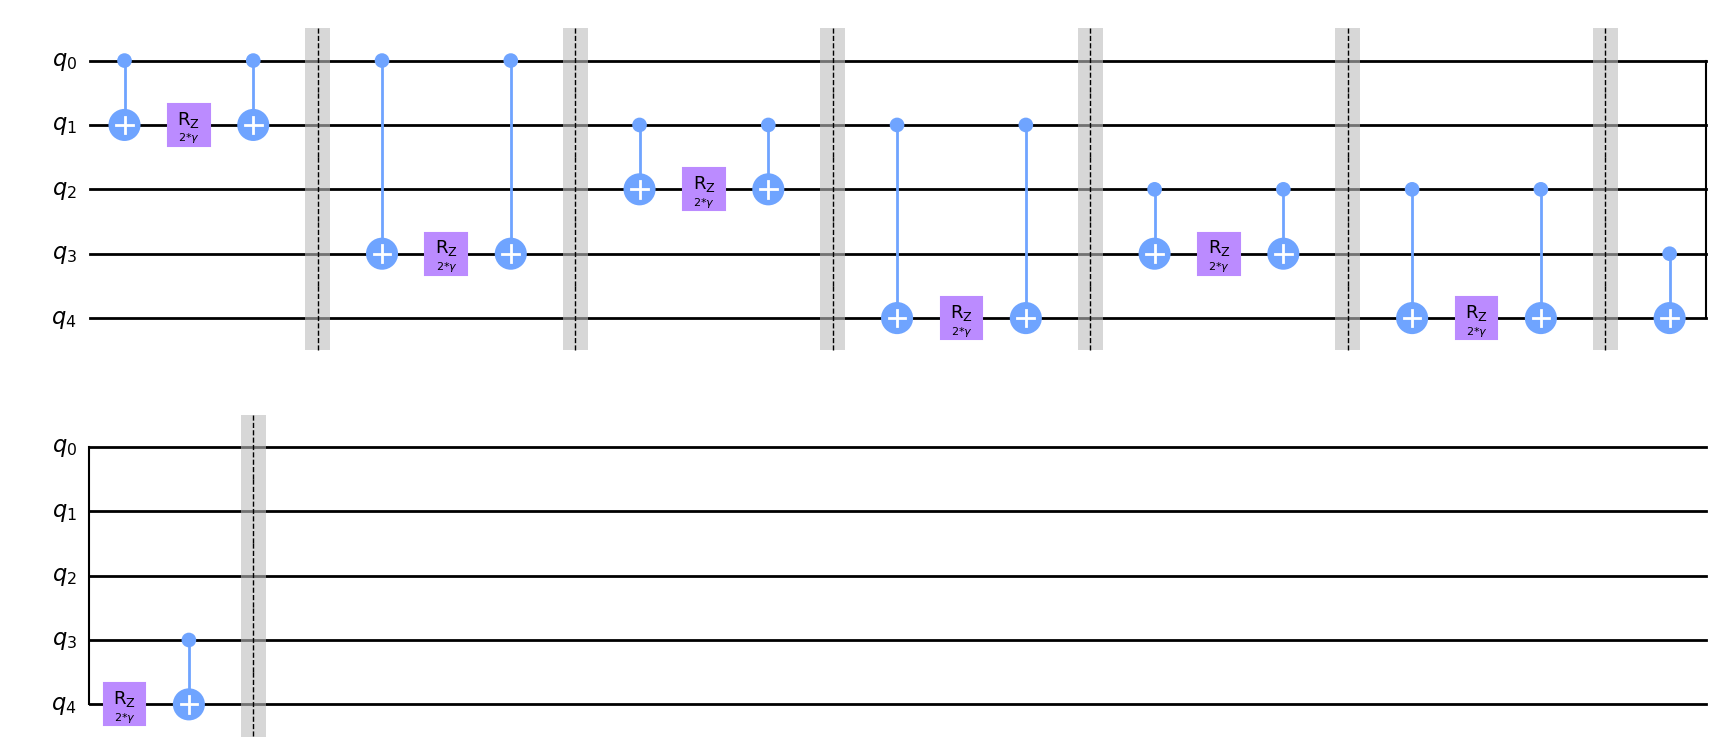

In [2]:
gamma = Parameter("$\\gamma$")
qc_p = QuantumCircuit(N_QUBITS)
for pair in list(graph.edges()):  # pairs of nodes
    qc_p.rzz(2 * gamma, pair[0], pair[1])
    qc_p.barrier()

qc_p.decompose().draw("mpl")

In [3]:
# X-Mixer
def x_mixer(qc, n, b):
    for i in range(n):
        qc.rx(2 * b, i)
    return qc

# XY-Mixer
def U_theta(theta):
    arr = np.array([[1,0,0,0],
                    [0,np.cos(theta/2), np.sin(theta/2), 0],
                    [0,np.sin(theta/2),np.cos(theta/2),0],
                    [0,0,0,1]])
    u_gate = UnitaryGate(data = arr)
    return u_gate

def xy_mixer_ring(qc, n, b):
    for i in range(n-1):
        qc.append(XXPlusYYGate(2*b, 0), [i, i+1])
        #qc.rxx(2 * b, i, i+1)
        #qc.ryy(2 * b, i, i+1)
        
    qc.append(XXPlusYYGate(2*b, 0), [0, n-1])
    #qc.rxx(2 * b, 0, n-1)
    #qc.ryy(2 * b, 0, n-1)
    return qc


# Full-Mixer
def xy_mixer_full(qc, n, b):
    for i in range(n):
        for j in range(i+1, n):
            qc.rxx(2 * b, i, j)
            qc.ryy(2 * b, i, j)
    return qc
            
# Parity-Mixer
def xy_mixer_parity(qc, n, b):
    for i in range(n-1)[::2]:
        qc.rxx(2 * b, i, i+1)
        qc.ryy(2 * b, i, i+1)
    for i in range(n-1)[1::2]:
        qc.rxx(2 * b, i, i+1)
        qc.ryy(2 * b, i, i+1)
    return qc
    

### The Mixing Unitary (Hamiltonian)

/var/folders/8p/496z10y17tbgmn3tc_pgqrz40000gn/T/ipykernel_60439/113500781.py:4: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency = nx.adjacency_matrix(graph).todense()


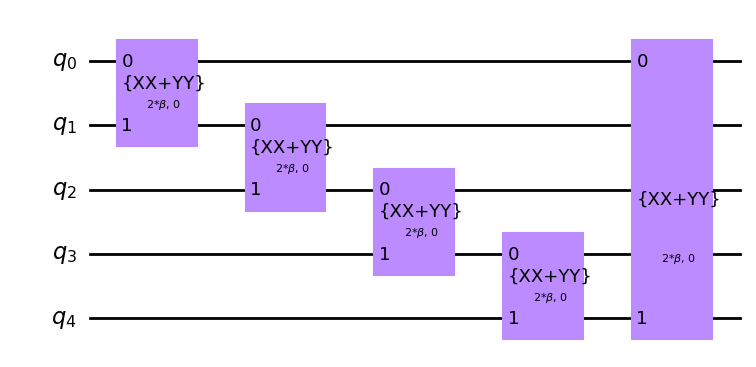

In [4]:


# Adjacency is essentially a matrix which tells you which nodes are
# connected. This matrix is given as a sparse matrix, so we need to
# convert it to a dense matrix
adjacency = nx.adjacency_matrix(graph).todense()

beta = Parameter("$\\beta$")
qc_mix = QuantumCircuit(N_QUBITS)
#qc_mix = qc_mix.bind_parameters({beta: math.pi})
qc_mix = xy_mixer_ring(qc_mix, N_QUBITS, beta)
qc_mix.draw("mpl")

## Initial State

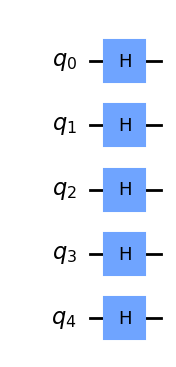

In [5]:
qc_0 = QuantumCircuit(N_QUBITS)
for i in range(N_QUBITS):
    qc_0.h(i)

qc_0.draw("mpl")

### The QAOA circuit

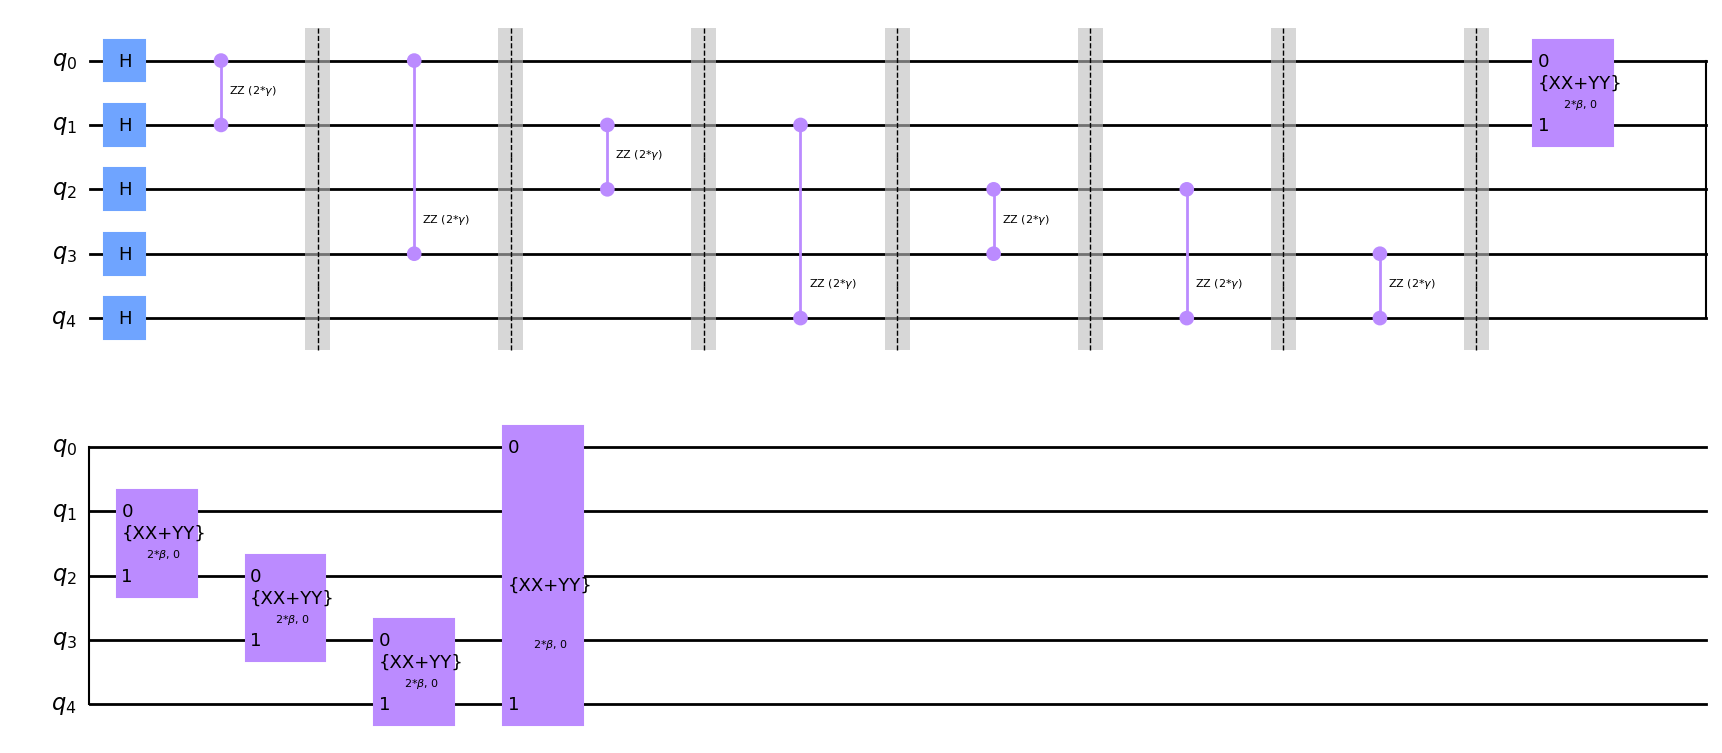

In [6]:
qc_qaoa = QuantumCircuit(N_QUBITS)
qc_qaoa.append(qc_0, range(N_QUBITS))
qc_qaoa.append(qc_p, range(N_QUBITS))
qc_qaoa.append(qc_mix, range(N_QUBITS))

qc_qaoa.decompose().decompose().draw()

qc_qaoa.decompose().draw("mpl")

In [7]:
def maxcut_obj(solution, graph):
    """Given a bit string as a solution, this function returns
    the number of edges shared between the two partitions
    of the graph.
    Args:
        solution: (str) solution bit string
        graph: networkx graph
    Returns:
        obj: (float) Objective
    """
    obj = 0
    for i, j in graph.edges():
        if solution[i] != solution[j]:
            obj -= 1
    return obj


def compute_expectation(counts, graph):
    """Computes expectation value based on measurement results
    Args:
        counts: (dict) key as bit string, val as count
        graph: networkx graph
    Returns:
        avg: float
             expectation value
    """
    avg = 0
    sum_count = 0
    for bit_string, count in counts.items():
        obj = maxcut_obj(bit_string, graph)
        avg += obj * count
        sum_count += count
    return avg/sum_count


# We will also bring the different circuit components that
# build the qaoa circuit under a single function
def create_qaoa_circ(graph, theta):
    """Creates a parametrized qaoa circuit
    Args:
        graph: networkx graph
        theta: (list) unitary parameters
    Returns:
        (QuantumCircuit) qiskit circuit
    """
    nqubits = len(graph.nodes())
    n_layers = len(theta)//2  # number of alternating unitaries
    beta = theta[:n_layers]
    gamma = theta[n_layers:]

    qc = QuantumCircuit(nqubits)

    # initial_state
    qc.h(range(nqubits))

    for layer_index in range(n_layers):
        # problem unitary
        for pair in list(graph.edges()):
            qc.rzz(2 * gamma[layer_index], pair[0], pair[1])
        # mixer unitary
        
        qc = xy_mixer_ring(qc, nqubits, beta[layer_index])

    qc.measure_all()
    return qc


# Finally we write a function that executes the circuit
# on the chosen backend
def get_expectation(graph, shots=2048):
    """Runs parametrized circuit
    Args:
        graph: networkx graph
    """
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots

    def execute_circ(theta):
        qc = create_qaoa_circ(graph, theta)
        counts = backend.run(qc, nshots=2048).result().get_counts()
        return compute_expectation(counts, graph)

    return execute_circ

In [ ]:
from scipy.optimize import minimize
expectation = get_expectation(graph)
res = minimize(expectation,
               [1.0, 1.0],
               method='COBYLA')
res

Traceback (most recent call last):
capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.
  File "/Users/pascalwindhager/anaconda3/lib/python3.10/site-packages/scipy/optimize/_cobyla_py.py", line 258, in calcfc
Fatal Python error: F2PySwapThreadLocalCallbackPtr: F2PySwapThreadLocalCallbackPtr: PyLong_AsVoidPtr failed
Python runtime state: initialized
    f = fun(np.copy(x), *args)
  File "/var/folders/8p/496z10y17tbgmn3tc_pgqrz40000gn/T/ipykernel_60439/4293249303.py", line 80, in execute_circ
  File "/Users/pascalwindhager/anaconda3/lib/python3.10/site-packages/qiskit_aer/jobs/utils.py", line 41, in _wrapper
    return func(self, *args, **kwargs)
  File "/Users/pascalwindhager/anaconda3/lib/python3.10/site-packages/qiskit_aer/jobs/aerjob.py", line 106, in result
    return self._future.result(timeout=timeout)
  File "/Users/pascalwindhager/anaconda3/lib/python3.10/concurrent/futures/_base.py", line 451, in result
    return self.__get_result()
  File "/Users/pascalw

In [1]:
from qiskit import BasicAer
from qiskit.visualization import plot_histogram
from qiskit.execute_function import execute

backend = Aer.get_backend('aer_simulator')
backend.shots = 2048

qc_res = create_qaoa_circ(graph, res.x)
print(qc_res.draw())

counts = execute(qc_res, backend).result().get_counts()
#counts = backend.run(qc_res, seed_simulator=5).result().get_counts()
plot_histogram(counts)



NameError: name 'Aer' is not defined

In [ ]:
for key, val in counts.items():
    if(val>=80):
        print(str(key)+" "+str(val))

In [ ]:
#xmixer
#01011 110
#10100 100
#xy mixer ring
#11010 103
#01010 145
#10101 135